In [1]:
"""Scripts for analyzing of phantom outputs.

This script analyze the photospheric properties by randomly select rays in 3D space

"""

'Scripts for analyzing of phantom outputs.\n\nThis script analyze the photospheric properties by randomly select rays in 3D space\n\n'

# Main

## Imports & Settings

In [2]:
import numpy as np
from numpy import pi
from astropy import units
import matplotlib.pyplot as plt
import matplotlib as mpl
#from moviepy.editor import ImageSequenceClip
#from os import path

In [3]:
# import my modules listed in ./main/

from main import clmuphantomlib as mupl
#from main.clmuphantomlib.readwrite import json_load
from main.clmuphantomlib.log import is_verbose, say
from main.clmuphantomlib.settings   import DEFAULT_SETTINGS as settings
from main.clmuphantomlib.units_util import get_val_in_unit #set_as_quantity, get_units_field_name, get_units_cgs
from main.clmuphantomlib.readwrite  import json_dump, json_load
from main.clmuphantomlib.eos_mesa   import EoS_MESA_opacity
from main.clmuphantomlib import MyPhantomDataFrames, get_eos
from main.clmuphantomlib.light import get_optical_depth_by_ray_tracing_3D
from multiprocessing import cpu_count, Pool #Process, Queue
NPROCESSES = 1 if cpu_count() is None else max(cpu_count(), 1)

/home/clmu/anaconda3/envs/clmu_1/lib/python3.11/site-packages/sarracen/kernels/cubic_spline.py:15: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(fastmath=True)
/home/clmu/anaconda3/envs/clmu_1/lib/python3.11/site-packages/sarracen/kernels/quartic_spline.py:15: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(fastmath=True)
/home/clmu/anaconda3/envs/clmu_1

In [4]:
# settings
#
#   imported from script_input.py file


from script_PhLocRand__input import verbose, out_dir, fps, unitsOut, JOB_PROFILES_DICT, PHOTOSPHERE_TAU, ray_no, cos_theta_sample_no

unitsOutTxt = {  key  : unitsOut[key].to_string('latex_inline') for key in unitsOut.keys() }


plt.rcParams.update({'font.size': 20})
if __name__ == '__main__' and is_verbose(verbose, 'note'):
    # remember to check if name is '__main__' if you wanna say anything
    #    so when you do multiprocessing the program doesn't freak out
    say('note', "script", verbose, f"Will use {NPROCESSES} processes for parallelization")


*   Note   :    script:
	Will use 8 processes for parallelization


In [5]:
def mpdf_read(
    job_name: str,
    file_index: int,
    eos_opacity: EoS_MESA_opacity,
    mpdf: MyPhantomDataFrames|None = None,
    verbose: int = 3,
) -> MyPhantomDataFrames:
    """Read the dump files and get T and kappa."""
    if mpdf is None:
        mpdf = MyPhantomDataFrames()

    mpdf.read(job_name, file_index, verbose=verbose)
    temp_key = {'T', 'temperature', 'Tdust'}.intersection(mpdf.data['gas'].keys()).pop()
    mpdf.data['gas']['T'    ] = mpdf.data['gas'][temp_key]
    if 'kappa' in mpdf.data['gas'].keys():
        mpdf.data['gas']['kappa'] = get_val_in_unit(mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
        kappa_mesa = eos_opacity.get_kappa(mpdf.get_val('rho'), mpdf.get_val('T'), do_extrap=False).to_value(mpdf.units['opacity'])
        kappa_gas  = (2e-4*(units.cm**2/units.g)).to(mpdf.units['opacity'])
        T_cond_oxy = 1450 * units.K
        mpdf.data['gas']['kappa'] = np.where(
            mpdf.data['gas']['T'] < T_cond_oxy, mpdf.data['gas']['kappa'], mpdf.data['gas']['kappa'] - kappa_gas + kappa_mesa)
    else:
        raise NotImplementedError("non-dusty sims (no kappa column in dump files) not yet implemented")

    return mpdf

In [6]:
# plotting T vs inclination angle (combining negative and positive side of cos_theta)

def plot_ph_vals_vs_incl(
    job_nickname: str, #= '2md'
    file_index  : int, #= 17600
    var_name    : str, #= 'T'
    out_dir     : str = './',
    cos_theta_sample_no:  int|None = 20,  # give None/zero will plot scatter
    mpdf: MyPhantomDataFrames|None = None, #= MyPhantomDataFrames()
    verbose: int = 3,
) -> (mpl.figure.Figure, mpl.axes._axes.Axes):
    """Plotting photopshere variables vs inclination angle. (Figure is saved)"""

    # init
    units_field_names_dict = {
        'T'    : 'temp',
        'R1'   : 'dist',
        'rho'  : 'density',
        'kappa': 'opacity',
    }
    var_latex_dict = {
        'T'    : 'T_\\mathrm{ph}',
        'R1'   : 'R_\\mathrm{ph}',
        'rho'  : '\\rho_\\mathrm{ph}',
        'kappa': '\\kappa_\\mathrm{ph}',
    }
    var_description_dict = {
        'T'   : 'Temperature',
        'R1'  : 'Size',
        'rho' : 'Density',
        'kappa': 'Opacity',
    }
    unit_field_name = units_field_names_dict[var_name]
    var_latex = var_latex_dict[var_name]
    var_description = var_description_dict[var_name]
    
    
    # read data
    job_profile = JOB_PROFILES_DICT[job_nickname]
    job_name    = job_profile['job_name']
    params      = job_profile['params']
    ieos        = job_profile['ieos']
    eos         = get_eos(ieos, params, settings)
    eos_opacity = EoS_MESA_opacity(params, settings)
    mpdf        = mpdf_read(job_name, file_index, eos_opacity, mpdf, verbose=verbose)
    with open(f"{mpdf.get_filename()}__photosphere-vals.json", 'r') as f:
        vals_dict = json_load(f)
        vals_dict['abs_cos_theta'] = np.abs( vals_dict['cos_theta'])



    # plotting

    fig, ax = plt.subplots(figsize=(10, 8))

    x_all = vals_dict['abs_cos_theta']
    y_all = vals_dict[var_name].to_value(unitsOut[unit_field_name])

    y_total = np.average(y_all, axis=None)
    y_total_err = np.std(y_all, axis=None)

    y_range_mul = (y_all.max() - y_all.min()) * 0.1
    ylim = (y_all.min() - y_range_mul, y_all.max() + y_range_mul)


    if not cos_theta_sample_no: # None or zero
        ax.scatter(vals_dict['abs_cos_theta'], y_all, marker='.')
        halflen = 0
    else:
        # set up bins for x axis
        halflen = int(cos_theta_sample_no/2)
        ray_per_cos_theta = int(ray_no/cos_theta_sample_no)
        cos_theta_delta = 1. / cos_theta_sample_no
        cos_thetas = np.linspace(-1+cos_theta_delta, 1-cos_theta_delta, cos_theta_sample_no)[halflen:]
        indexes_list = np.stack([
            np.logical_and(
                cos_theta - cos_theta_delta < x_all,
                x_all <= cos_theta + cos_theta_delta
            ) for cos_theta in cos_thetas])
    
        x = cos_thetas #[np.average(vals_dict['abs_cos_theta'][indexes]) for indexes in indexes_list] #
        xerr = cos_theta_delta #[np.std(vals_dict['abs_cos_theta'][indexes]) for indexes in indexes_list]
    
        y = np.array([np.average(y_all[indexes]) for indexes in indexes_list])
        yerr =  np.array([np.std(y_all[indexes]) for indexes in indexes_list])
        ax.errorbar(x, y, yerr, xerr, 'o')

    

    ax.set_xlim((0., 1.))
    ax.set_ylim(ylim)
    ax.set_xlabel("$ | \\cos{\\theta} | $")
    ax.set_ylabel(f"${var_latex}$ / {unitsOutTxt[unit_field_name]}")

    ax.axhline(y_total, color='C1', linestyle='dashed')
    ax.fill_between((0., 1.), y_total-y_total_err, y_total+y_total_err, color='C1', alpha=0.15)
    
    ax.text(
        0.02, 0.98,
        f"Time = {mpdf.get_time():.1f}"
        f"\n Total ${var_latex} = {y_total:.1f}"
        f"\pm {y_total_err:.1f} $ {unitsOutTxt[unit_field_name]}",
        color = "black", ha = 'left', va = 'top',
        transform=ax.transAxes,
    )
    ax.set_title(
        f"Photosphere {var_description} ${var_latex}$ by inclination angle\n"
        f"{job_profile['plot_title_suffix']}"
    )



    functions = (
        lambda x: np.arccos(x) / pi * 180,
        lambda x: np.cos(x / 180 * pi),
    )
    secax = ax.secondary_xaxis('top', functions=functions)
    secax.set_xlabel(f"Inclination angle $\\theta$ / {units.degree}")
    secax.set_ticks(functions[0](ax.get_xticks()[:]))


    filename_dump = mupl.get_filename_phantom_dumps(job_nickname, file_index)
    outfilename_noext = f"{out_dir}{filename_dump}__photosphere-vals_{var_name}-vs-incl_nbin{halflen:d}"
    plt.savefig(f"{outfilename_noext}.png")
    if is_verbose(verbose, 'note'):
        say('note', 'plot_ph_vals_vs_incl()', verbose, f"Figure saved to {outfilename_noext}.png")

    return fig, ax

*   Note   :    MyPhantomDataFrames.read():
	
	Reading filename='../photosphere/luis_2md/light_00000'

*** Error  :    MyPhantomDataFrames.reset_xyz_by():
	Unknown coordinates cetner reseting center str what = ''
	Action Cancelled.
**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = 
		mupl.get_val_in_unit(mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
*   Note   :    plot_ph_vals_vs_incl():
	Figure saved to ../fig/2md_00000__photosphere-vals_T-vs-incl_nbin0.png
*   Note   :    MyPhantomDataFrames.read():
	
	Reading filename='../photosphere/luis_2md/light_00000'

*** Error  :    MyPhantomDataFrames.reset_xyz_by():
	Unknown coordinates cetner reseting center str what = ''
	Action Cancelled.
**  Wa

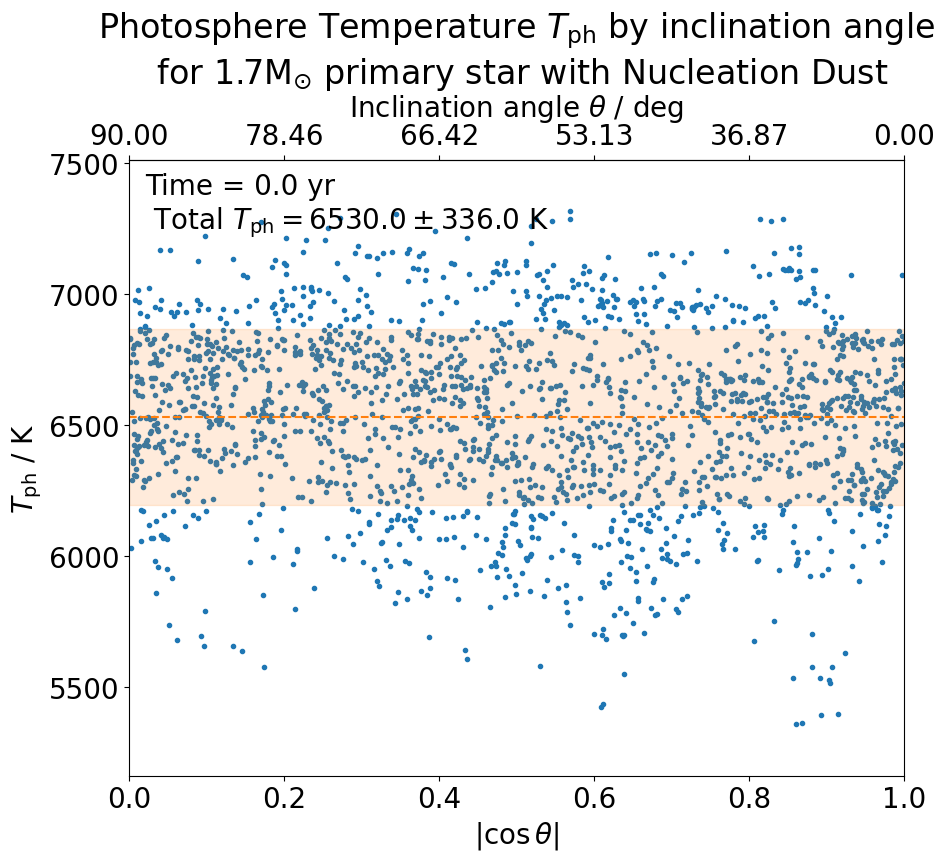

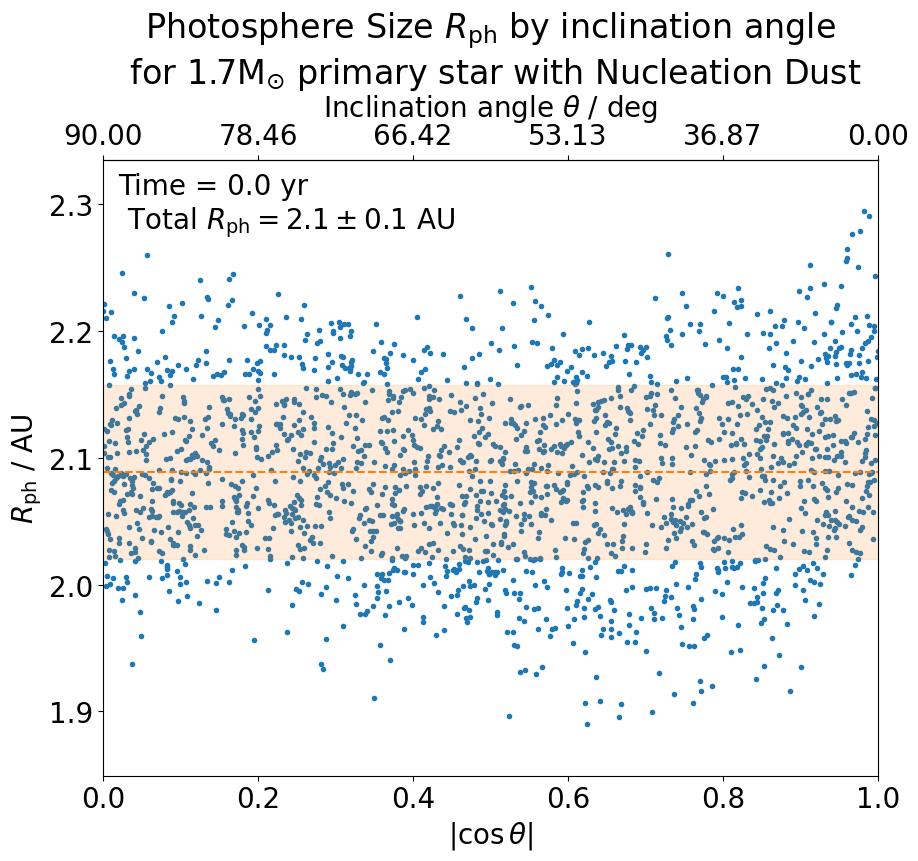

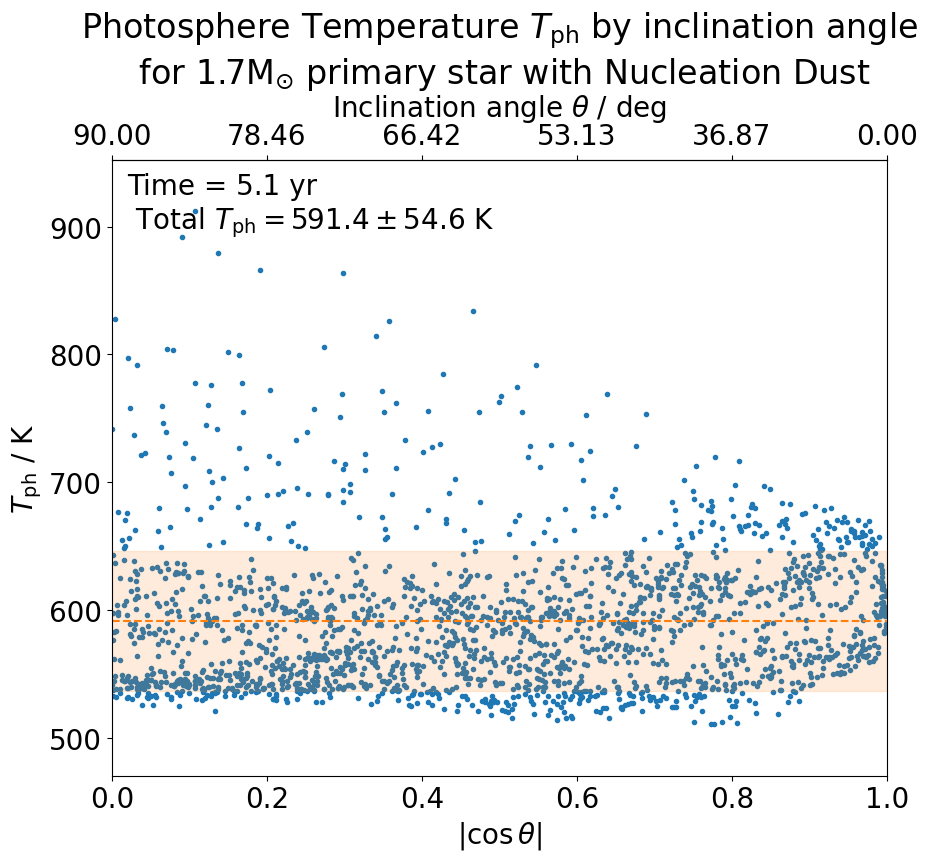

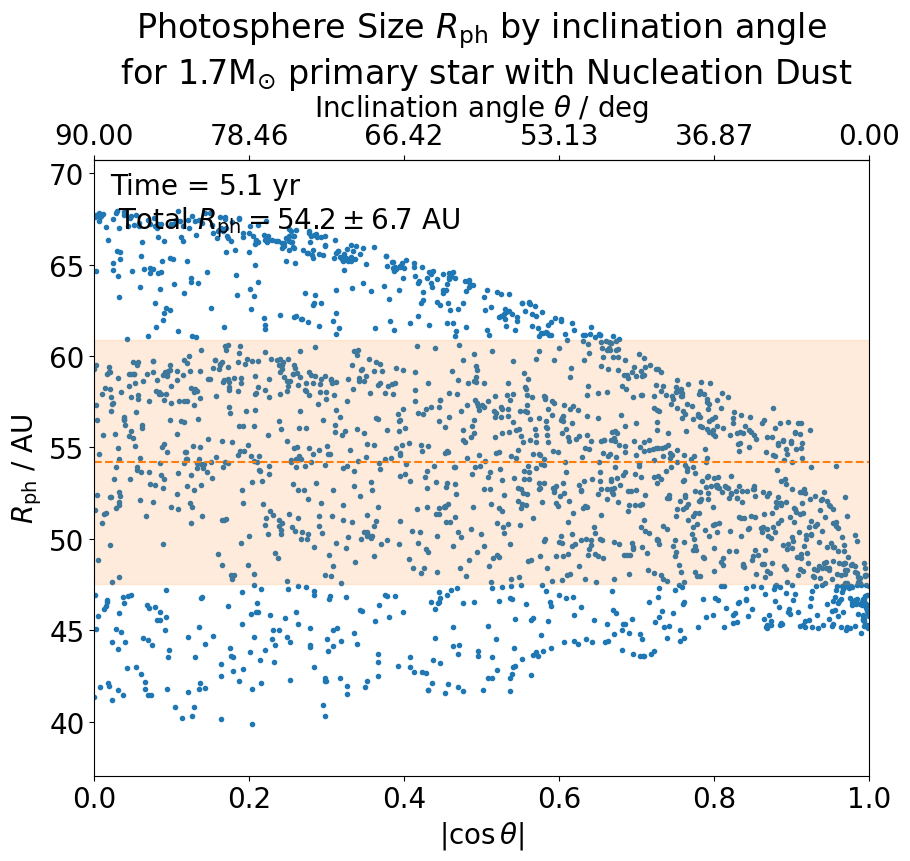

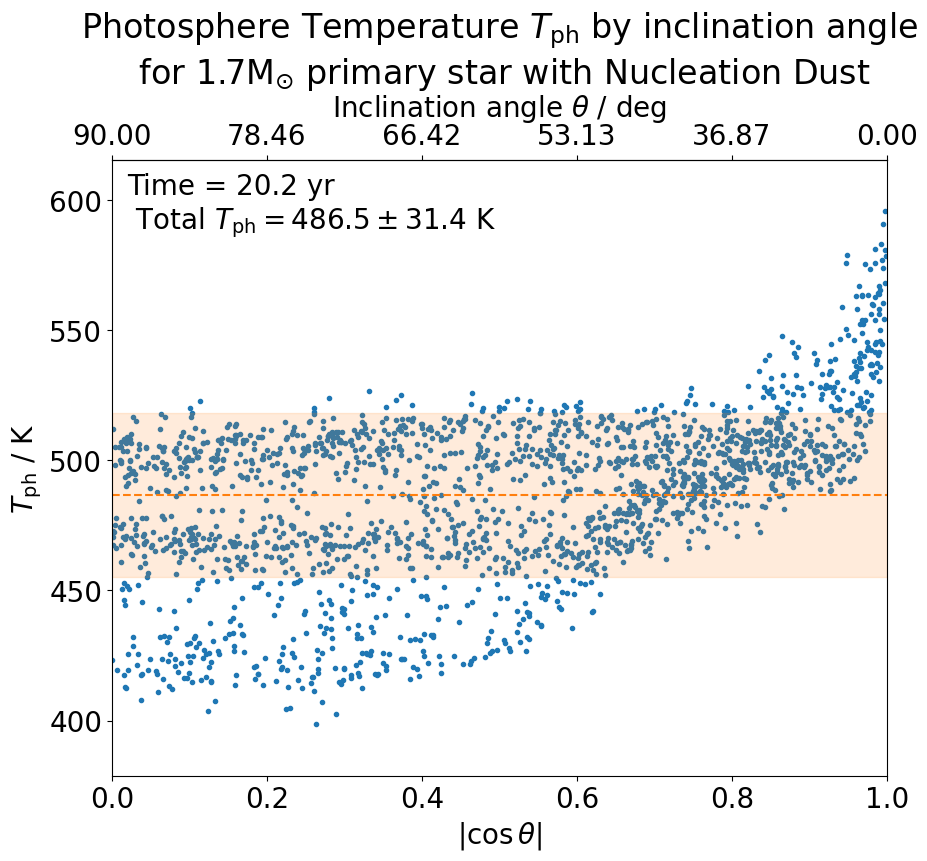

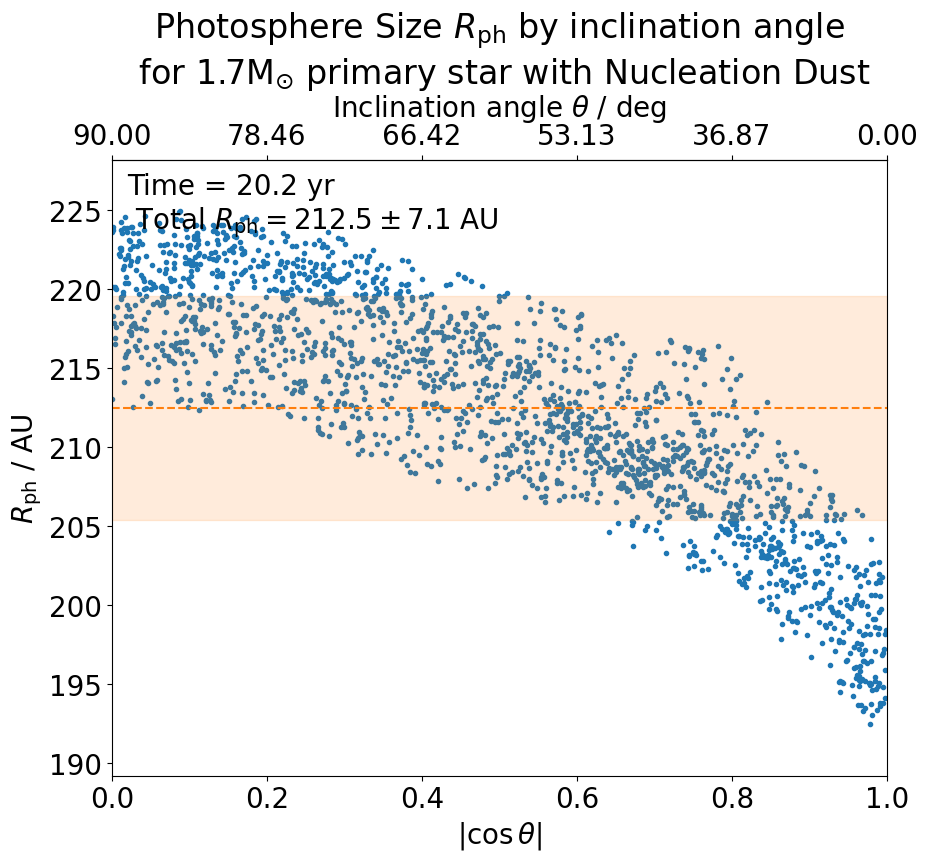

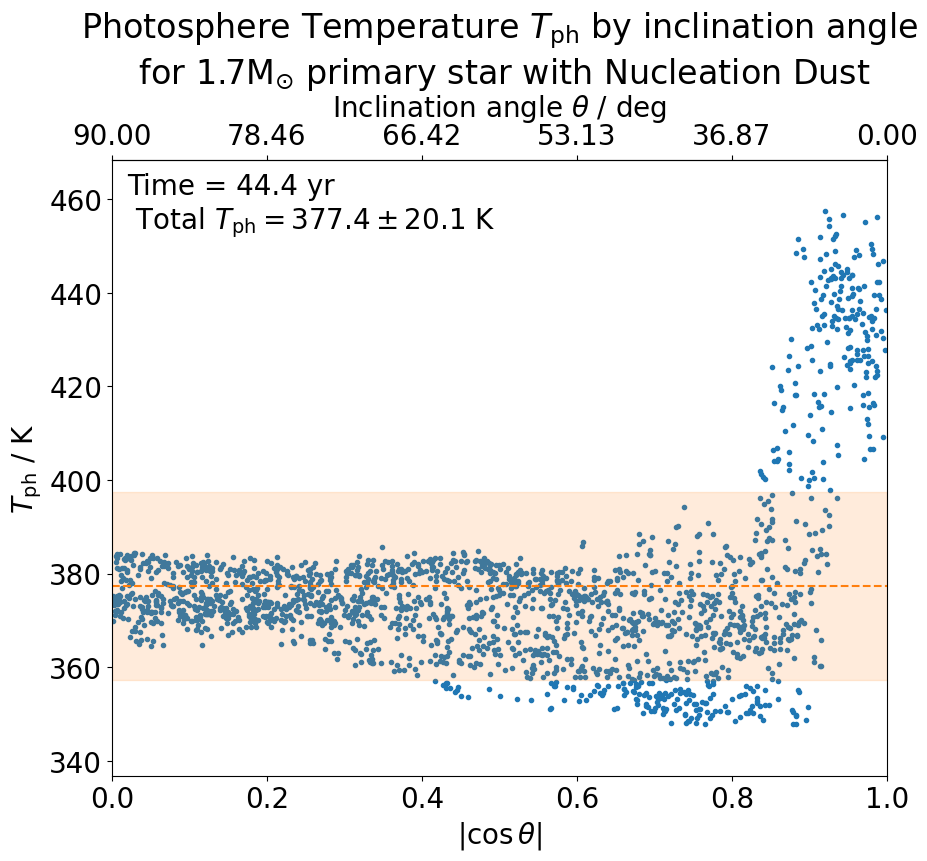

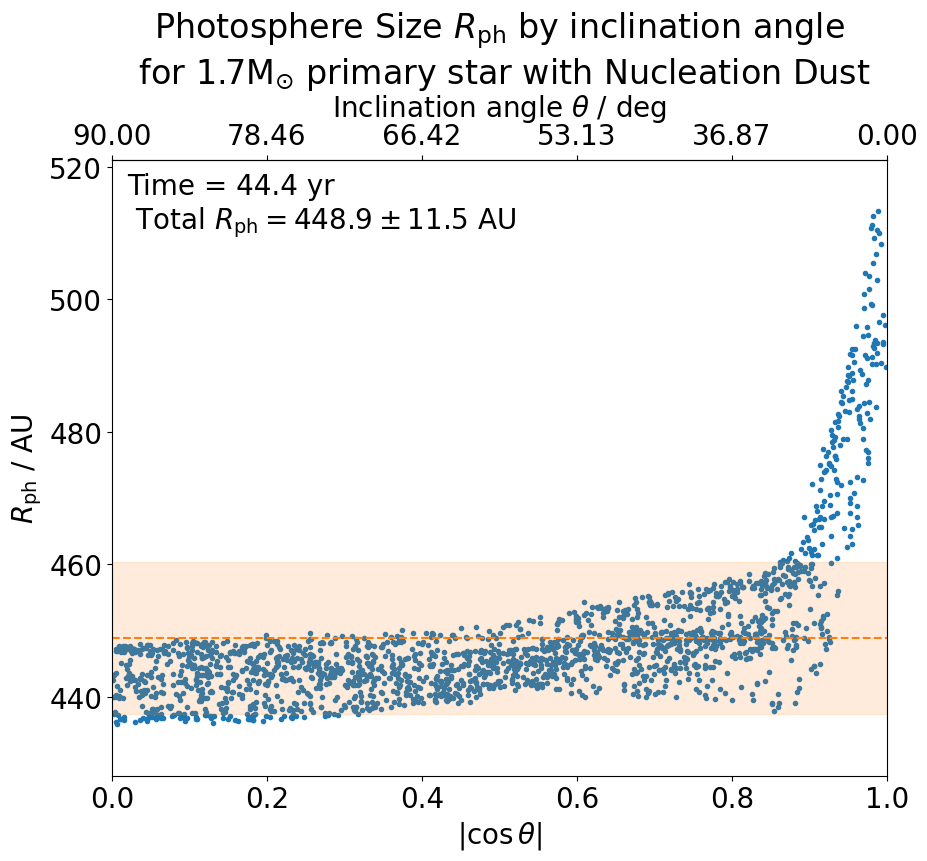

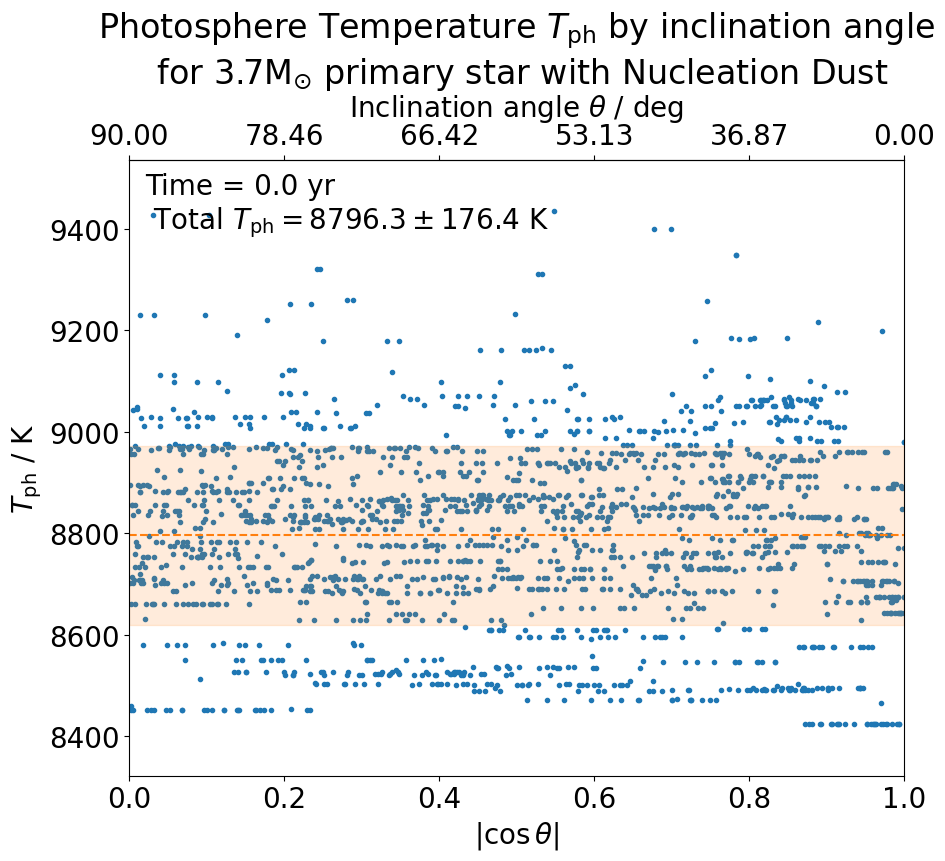

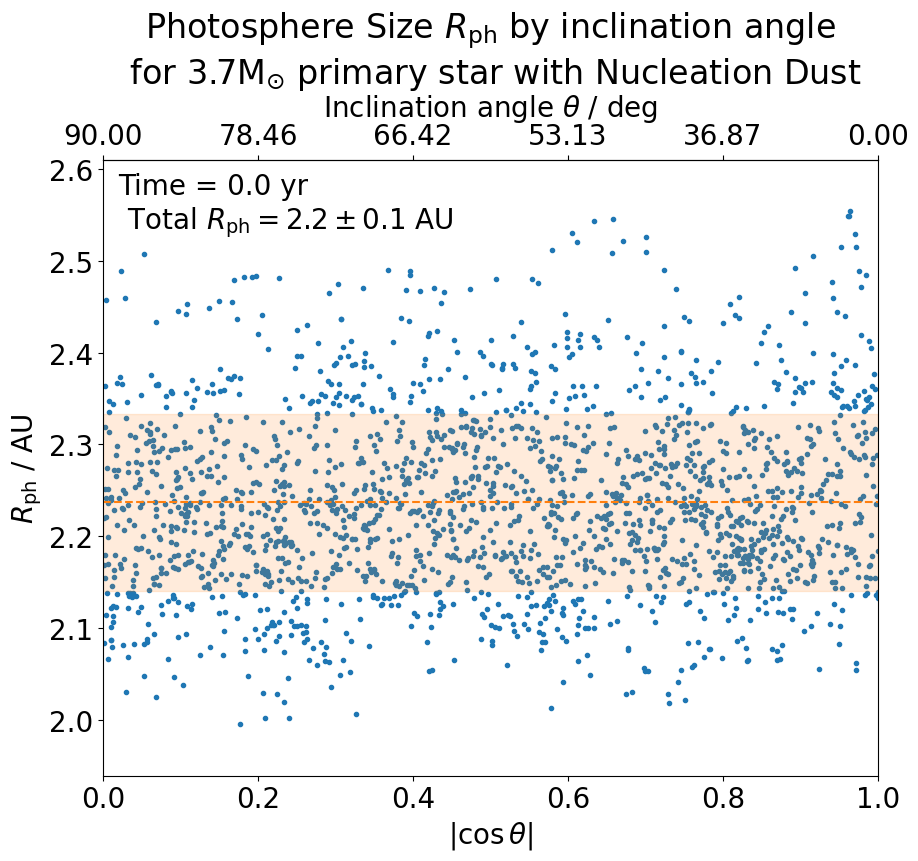

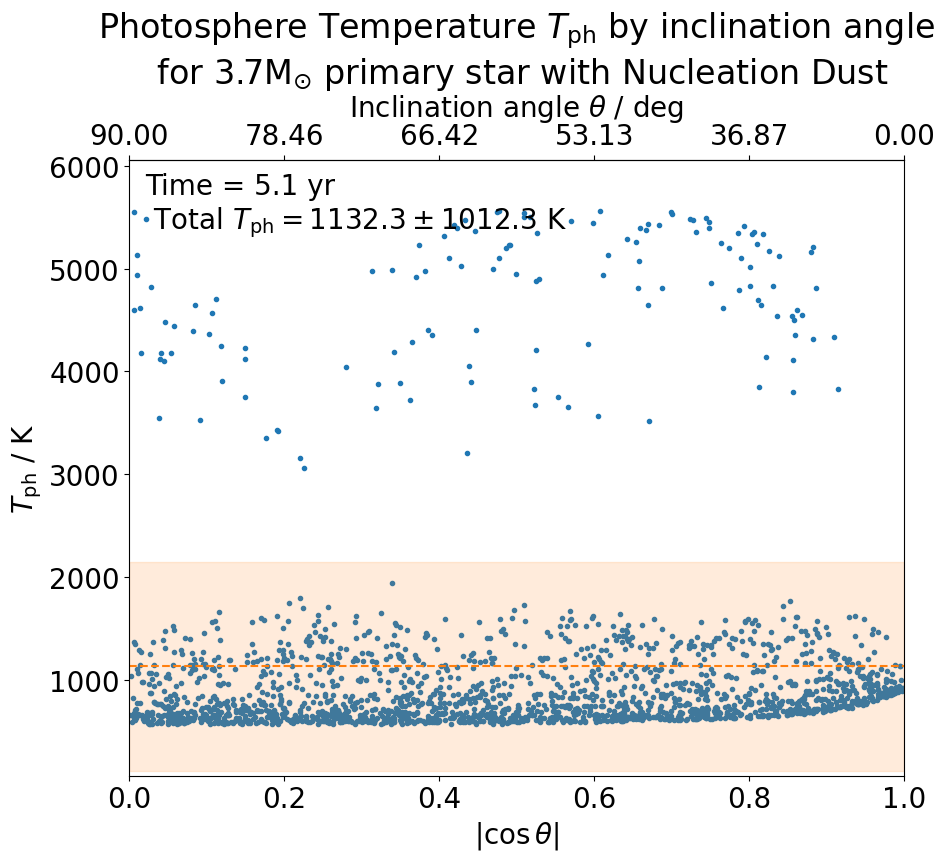

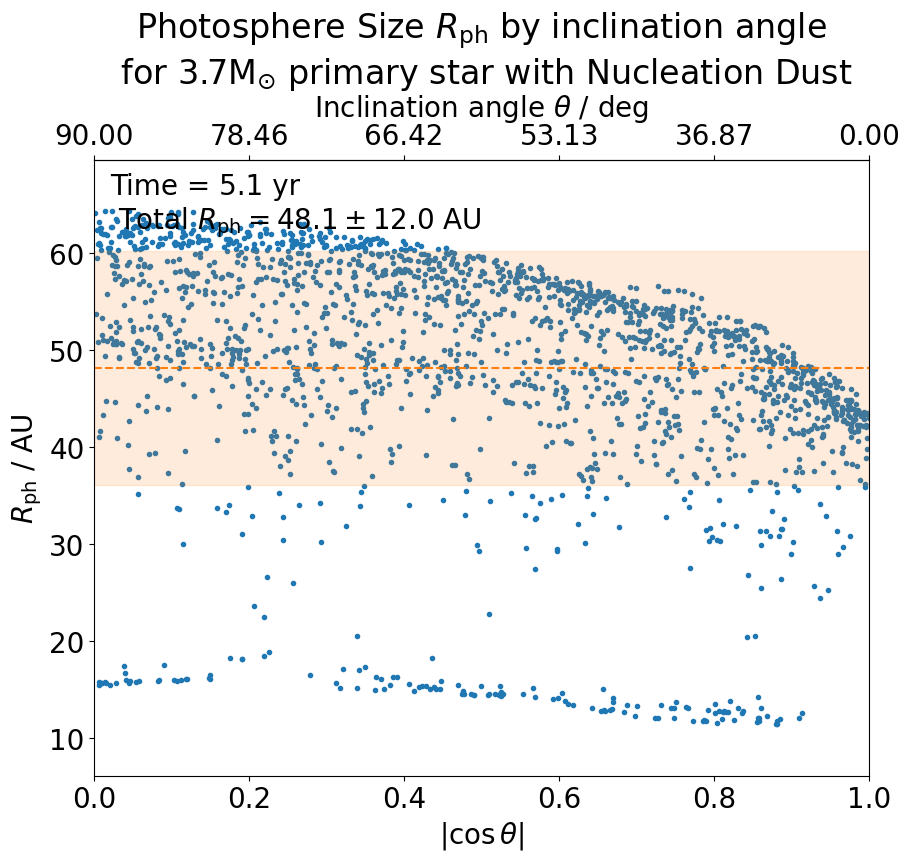

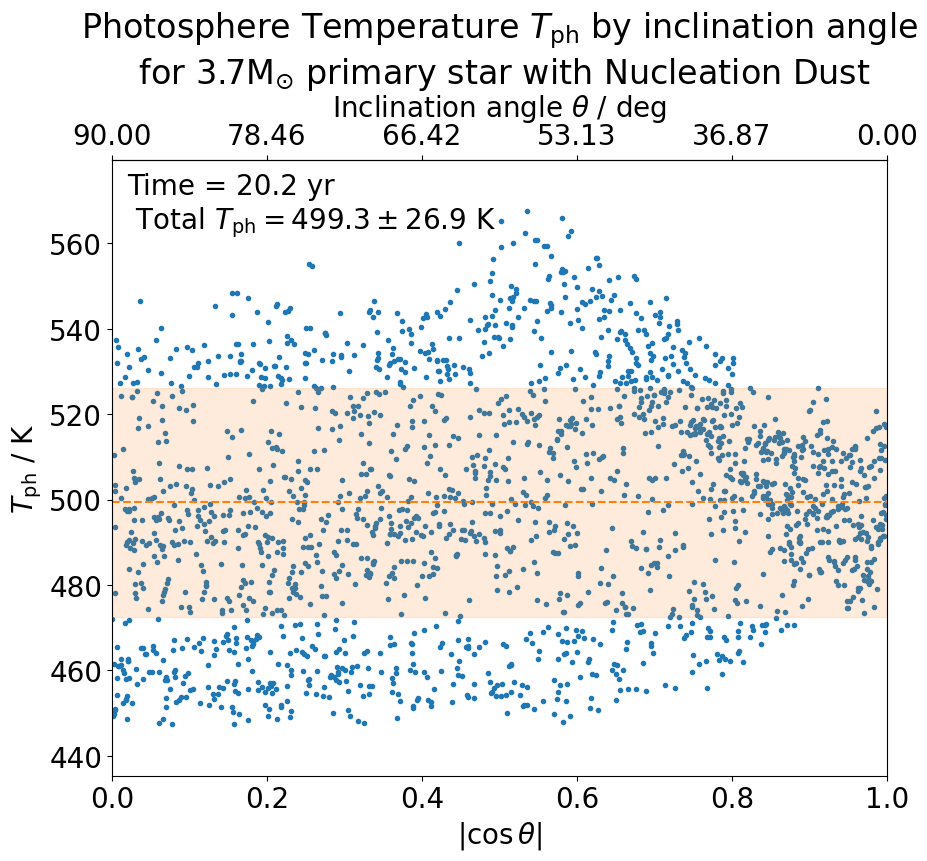

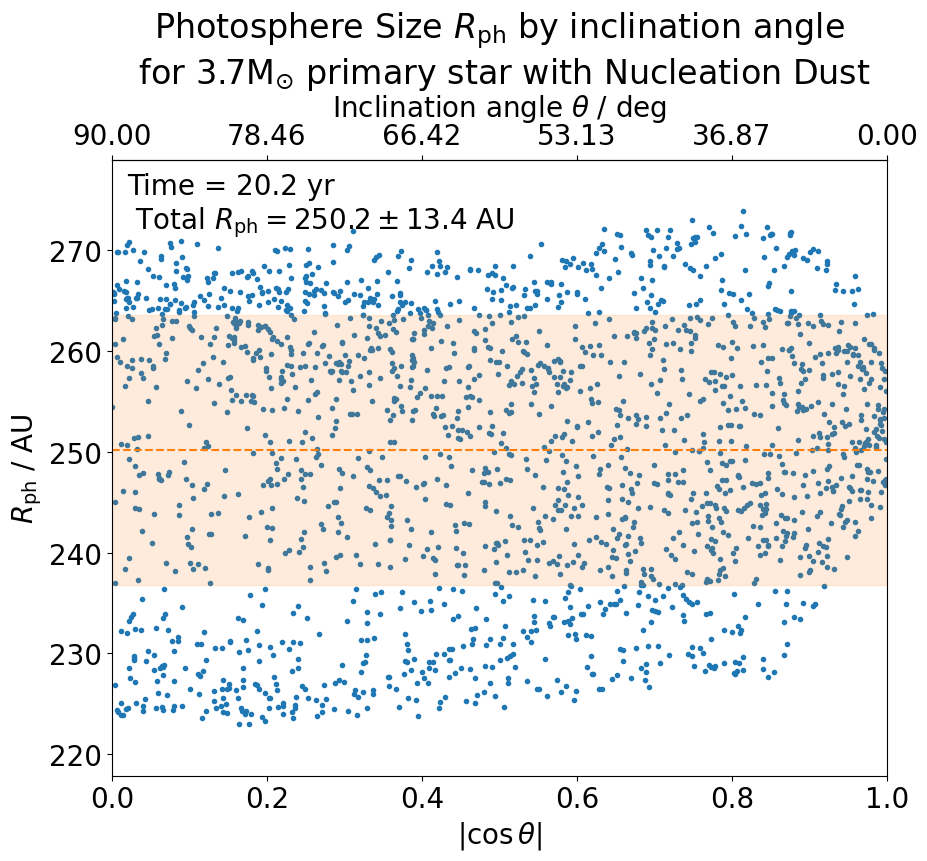

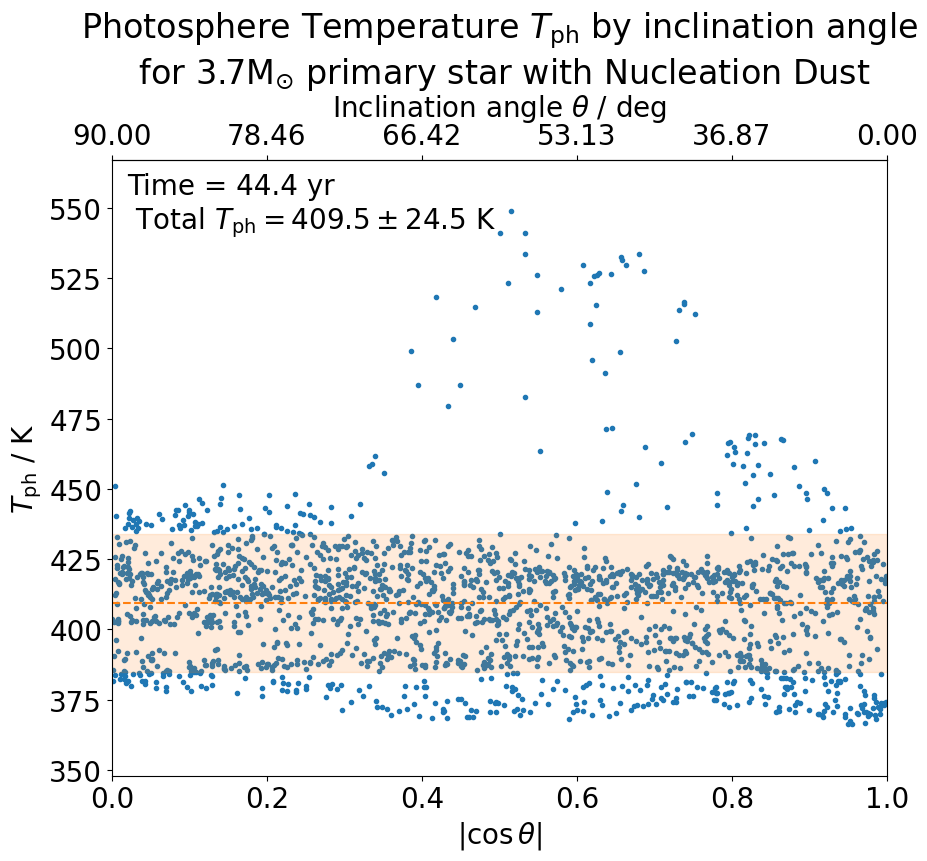

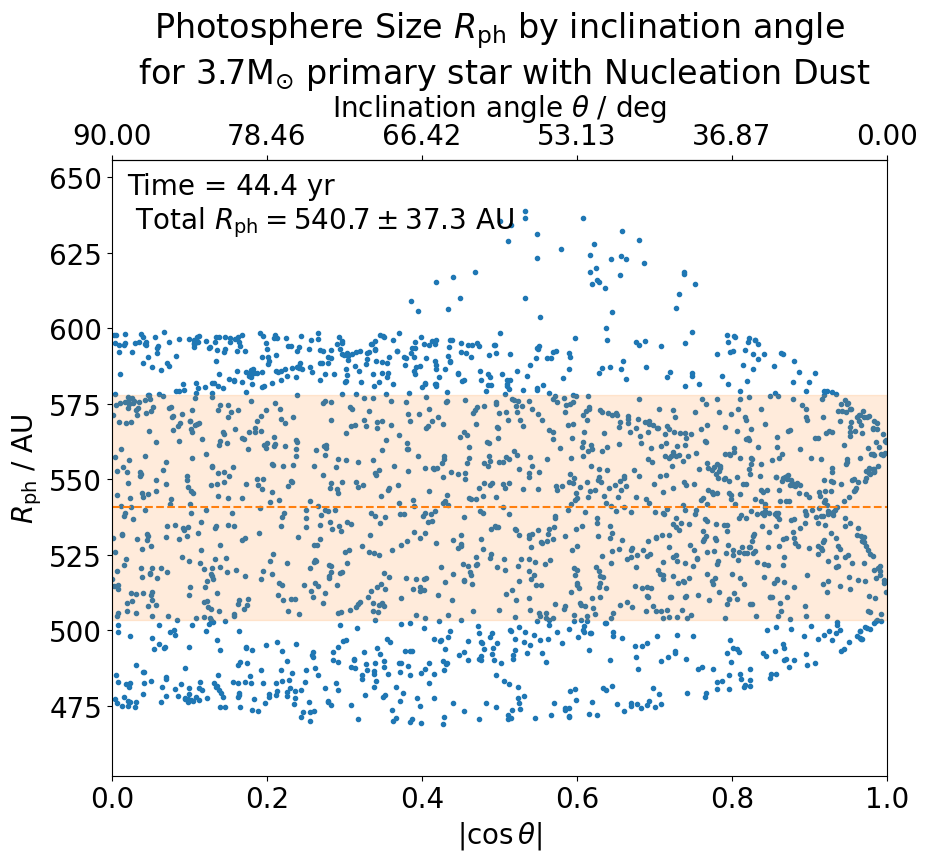

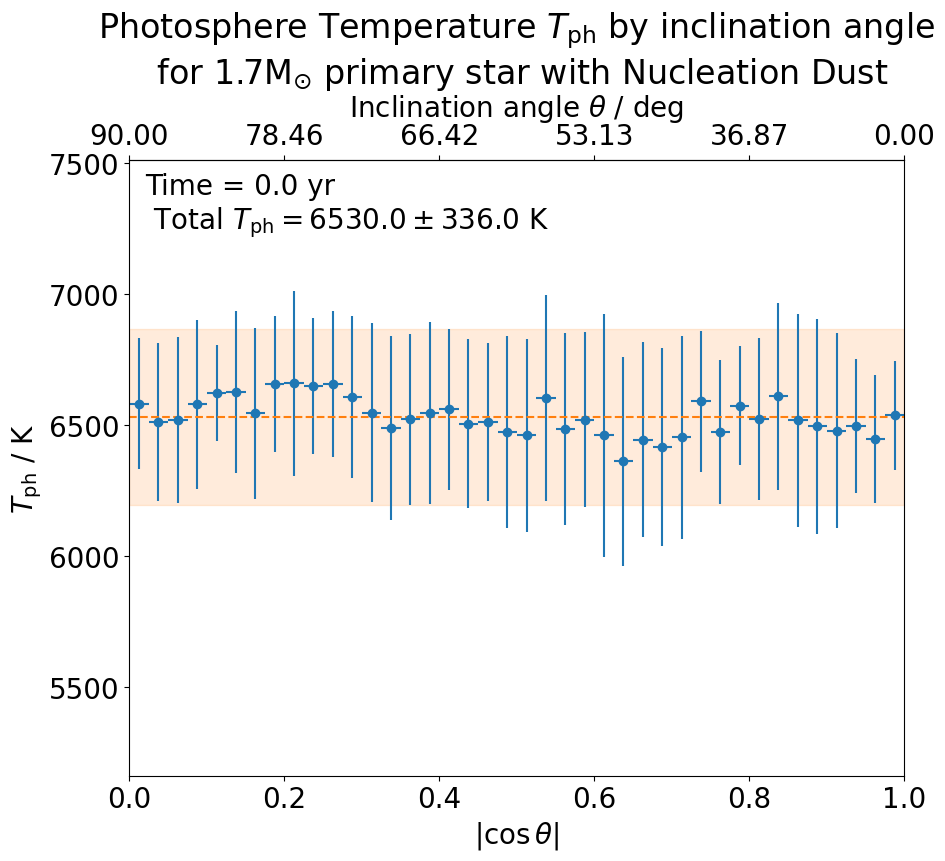

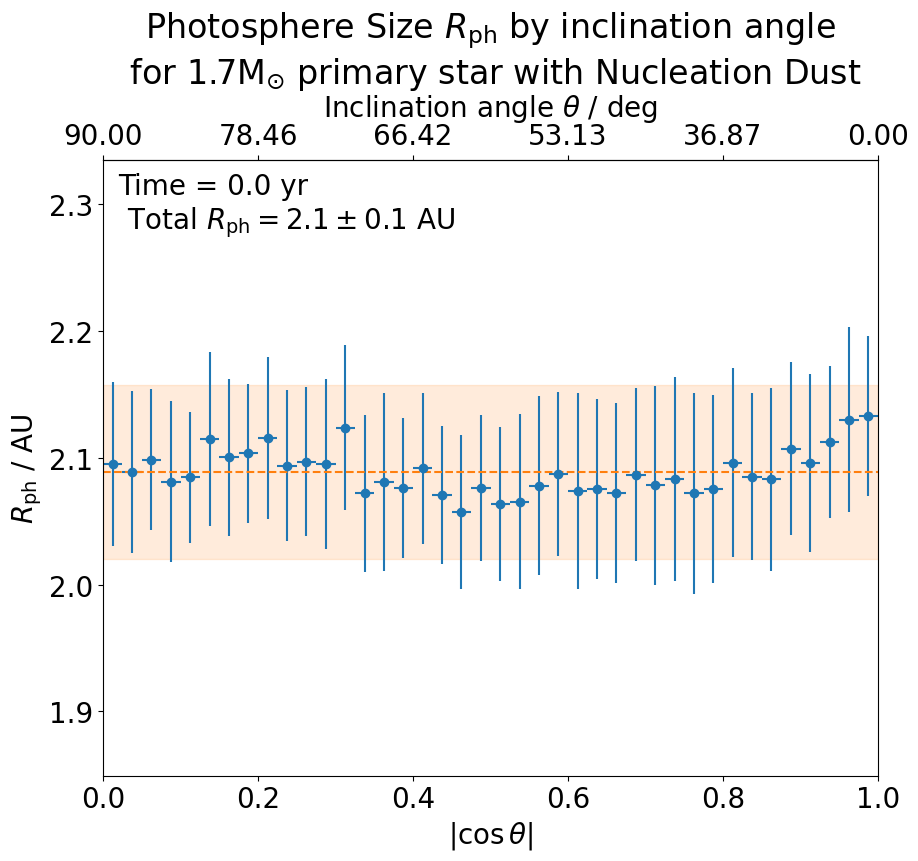

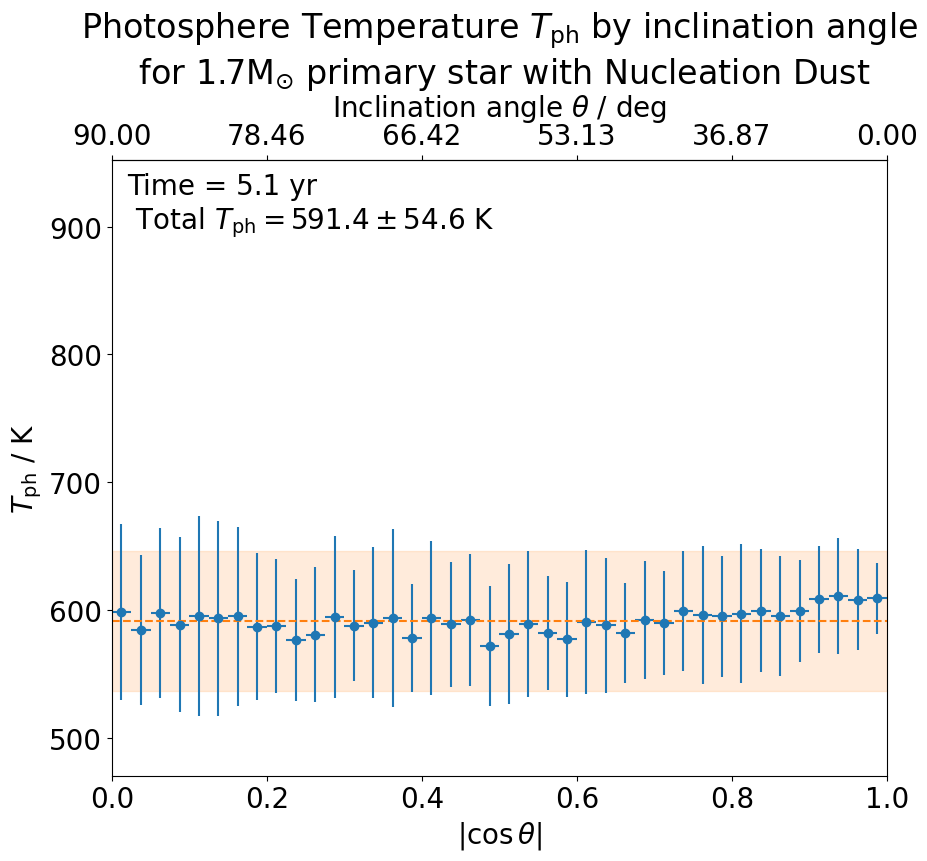

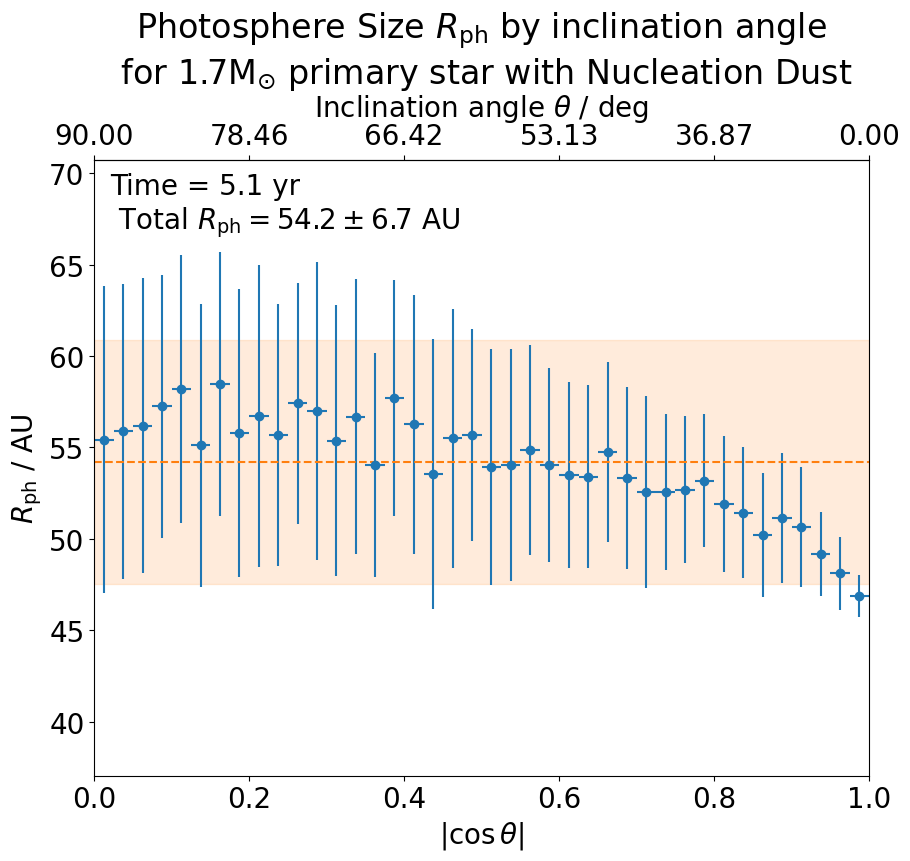

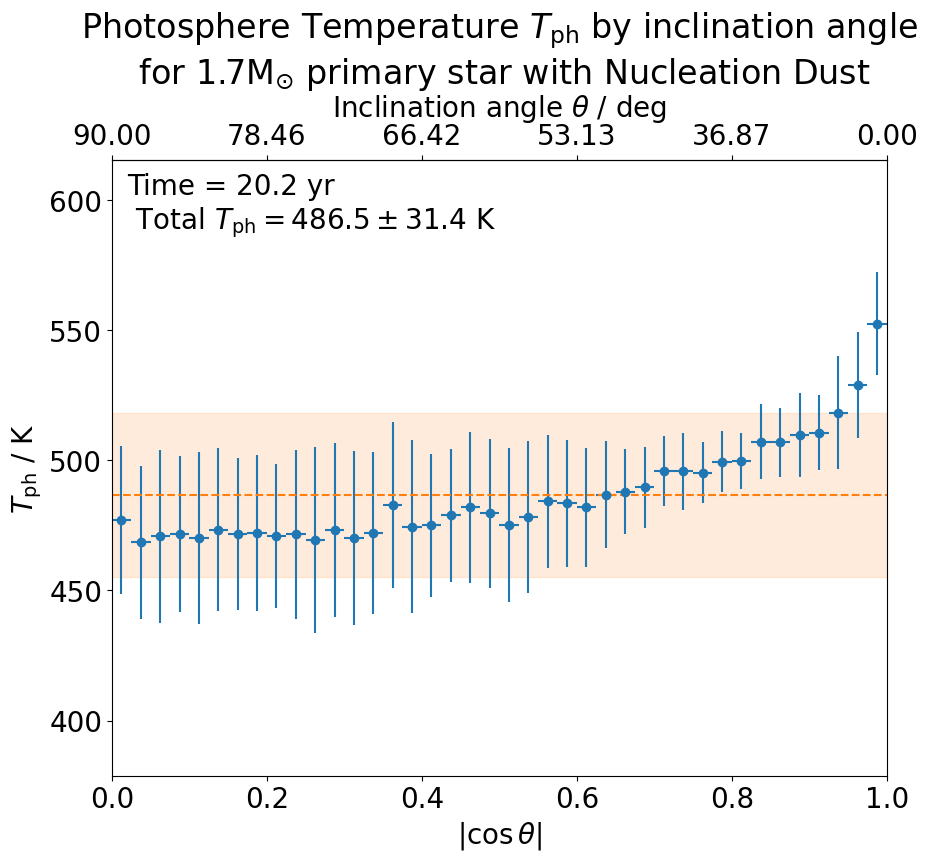

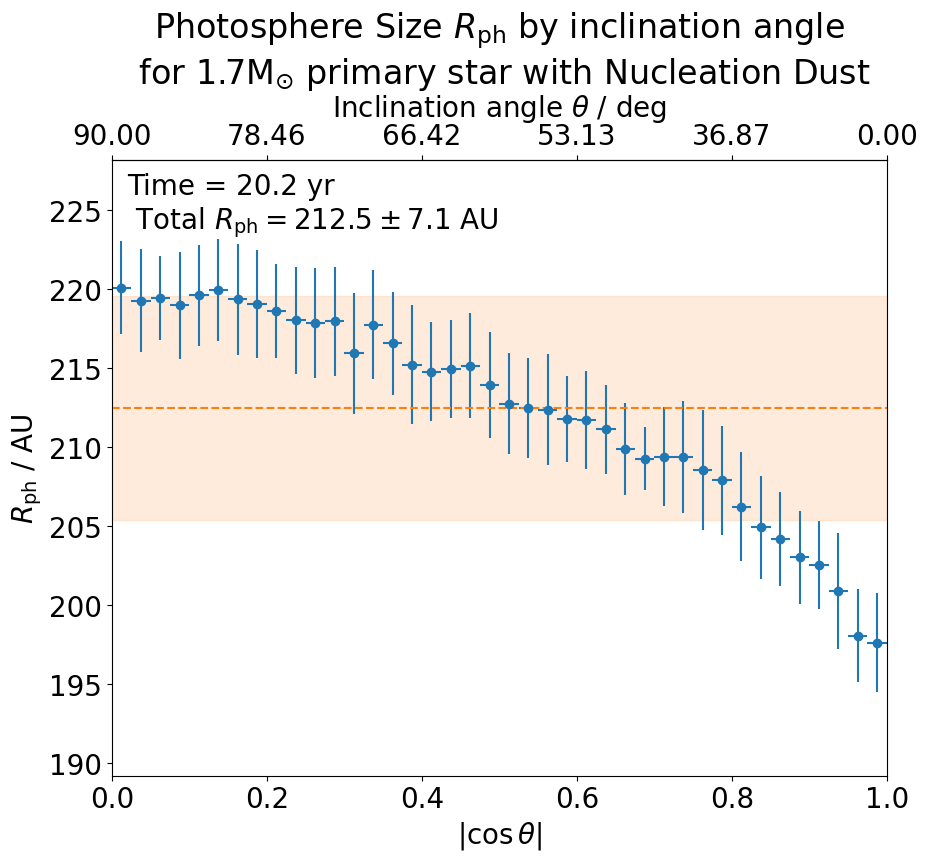

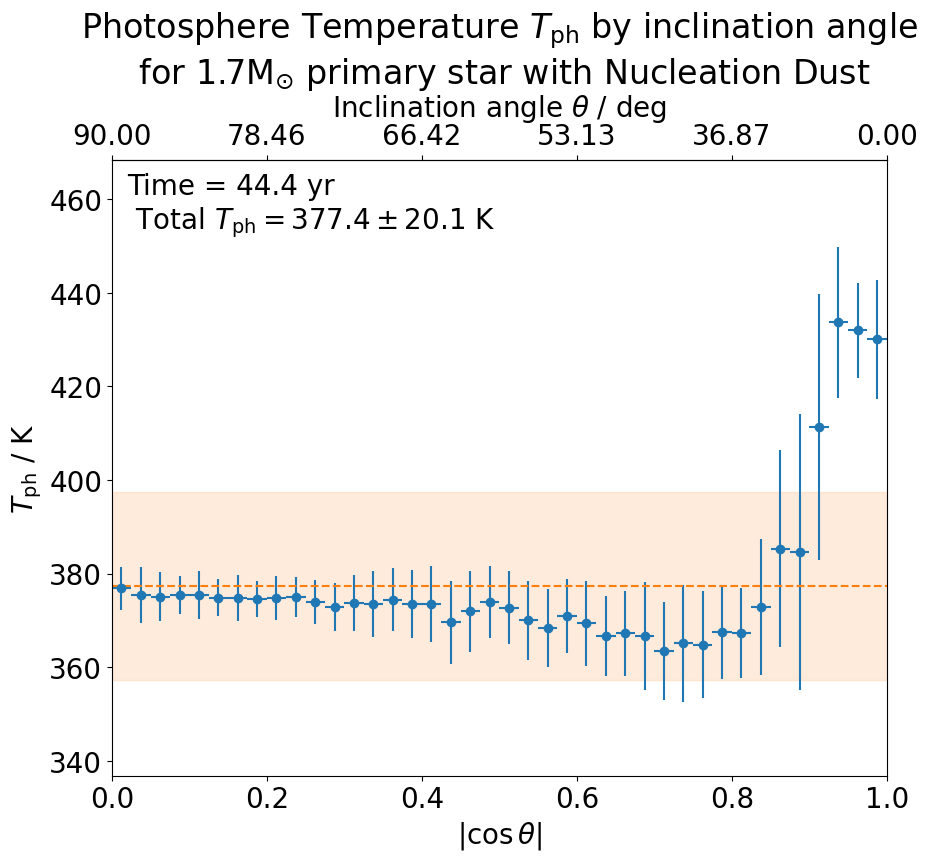

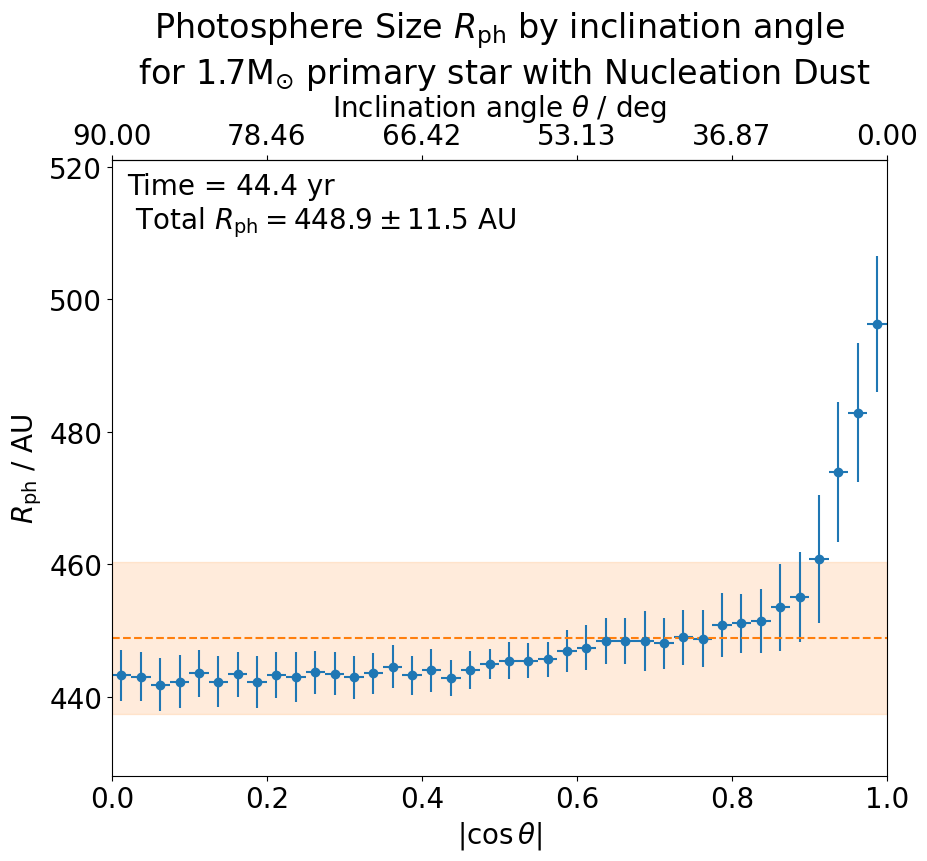

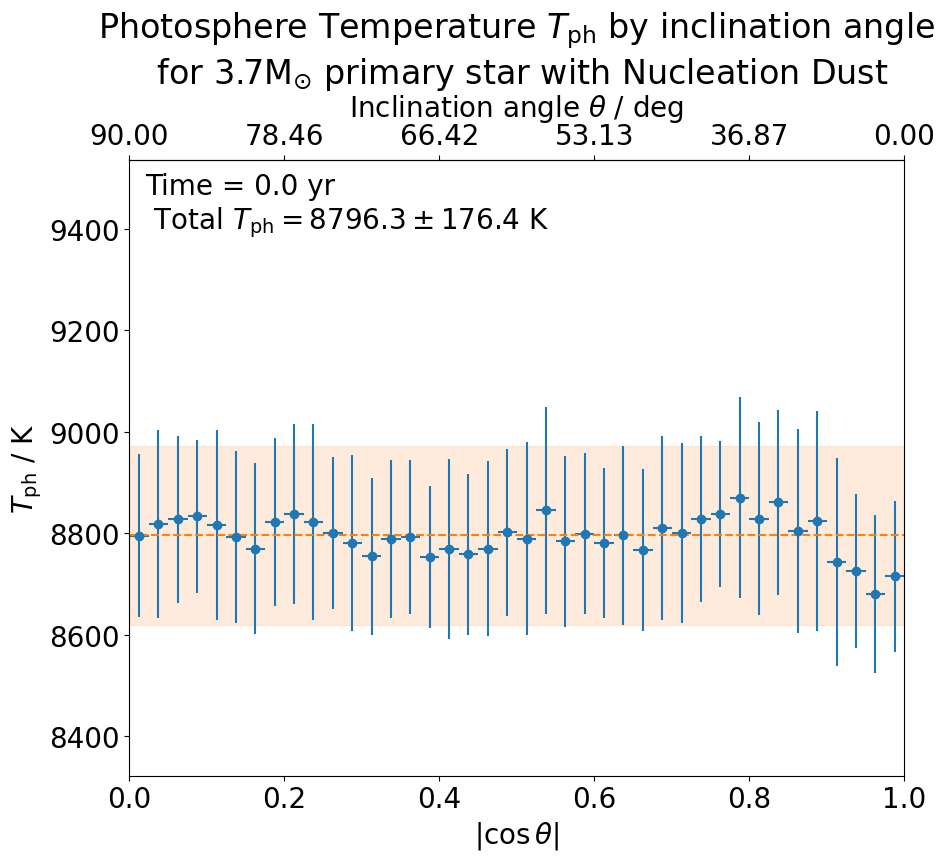

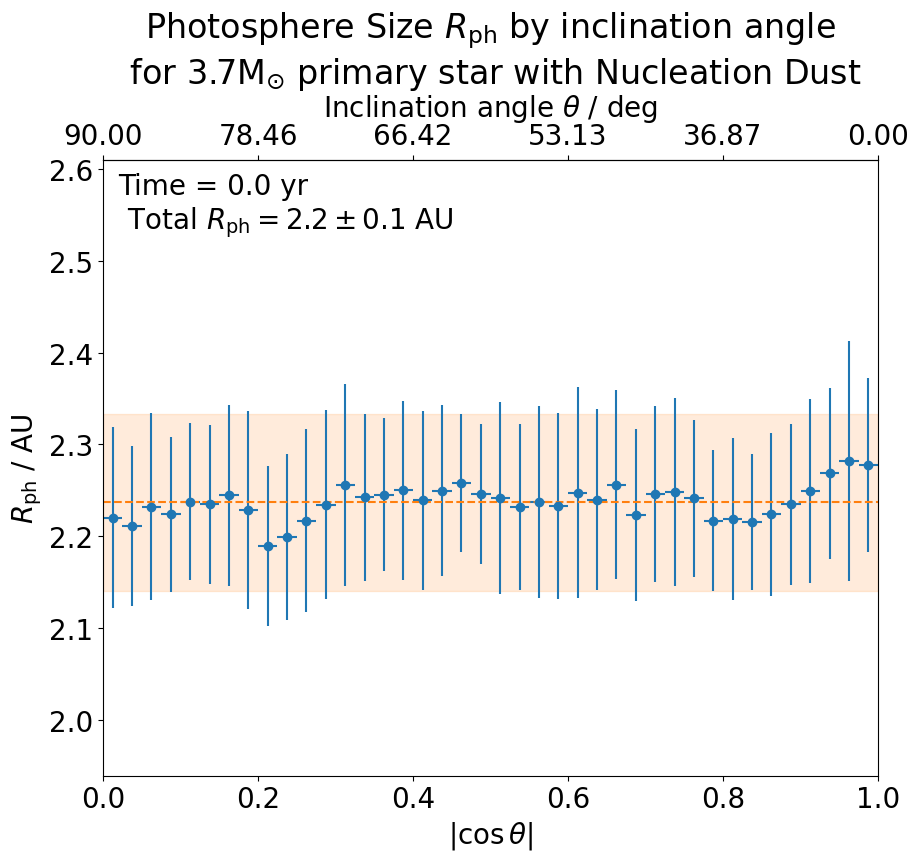

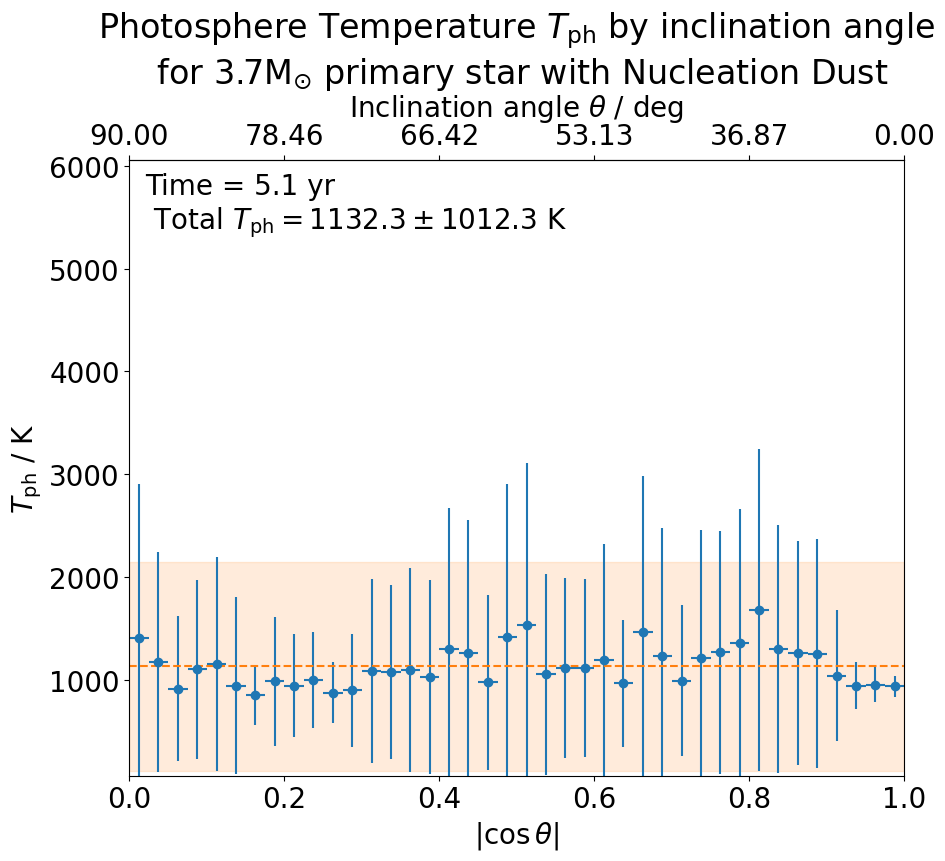

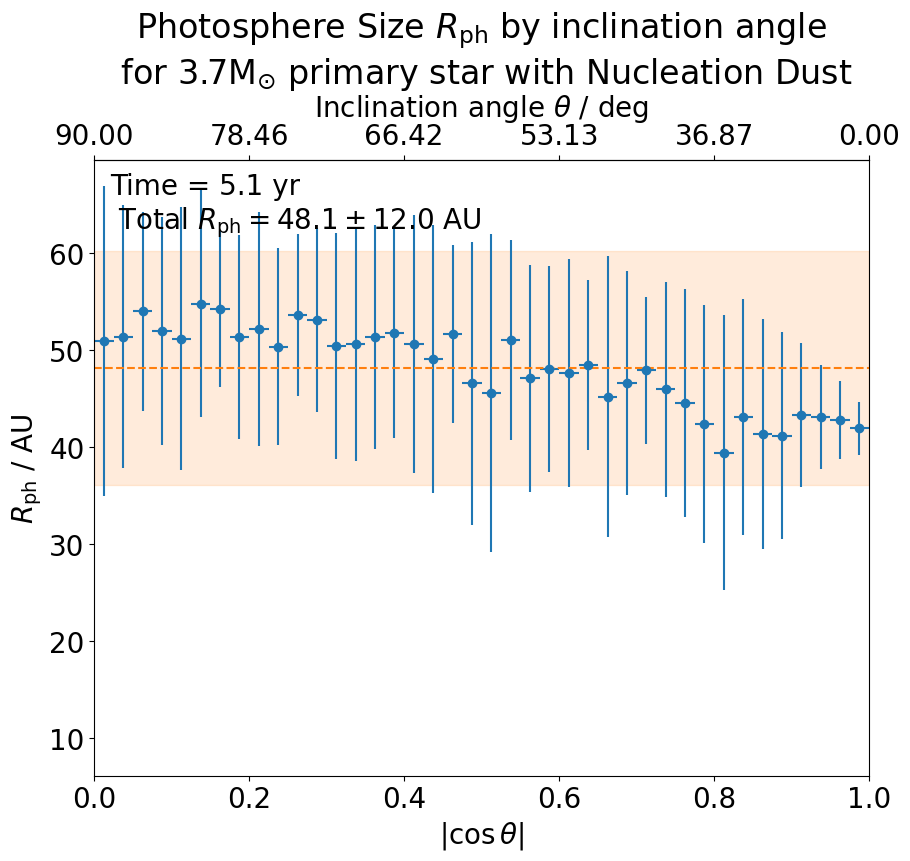

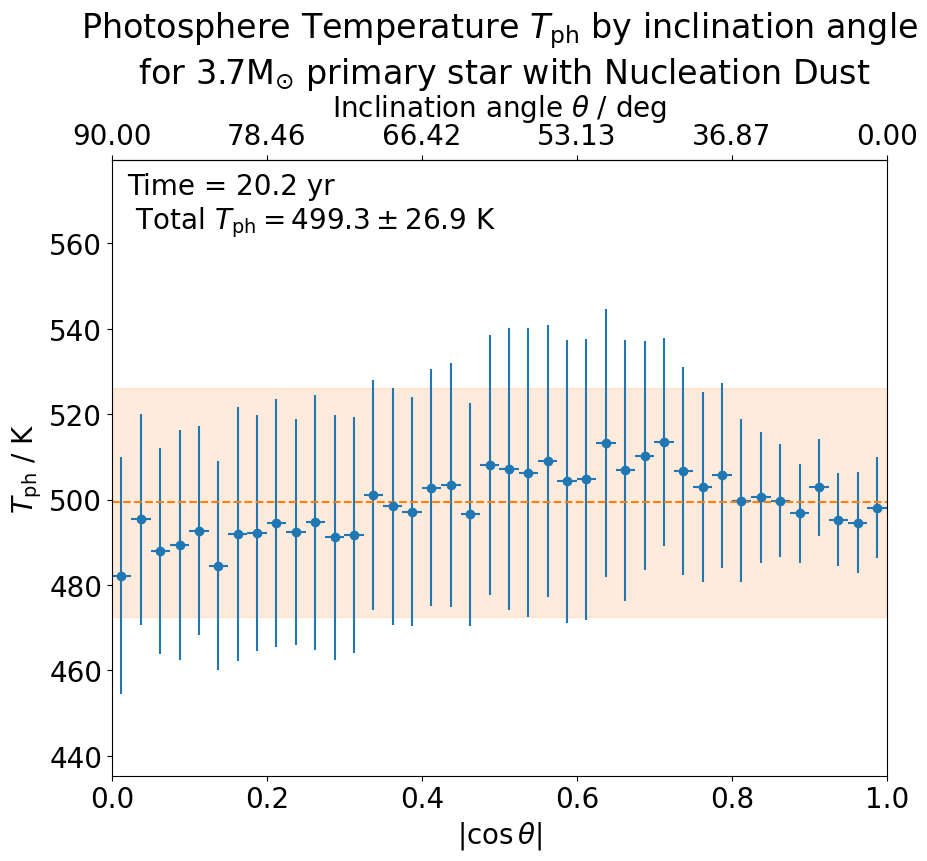

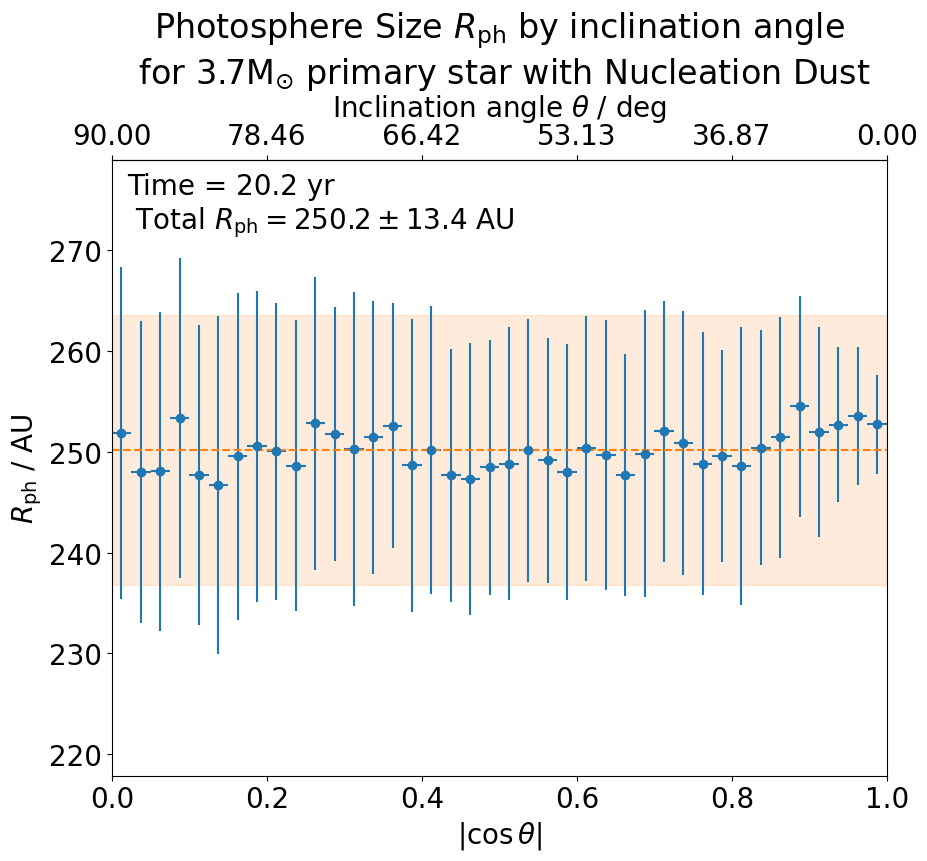

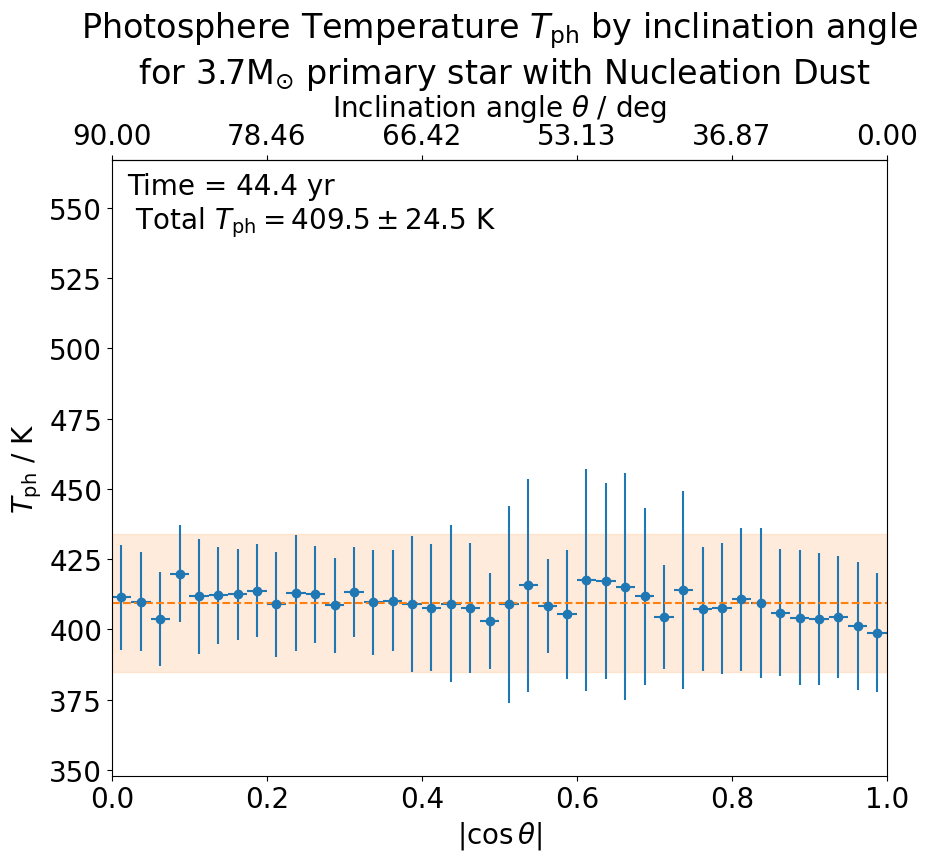

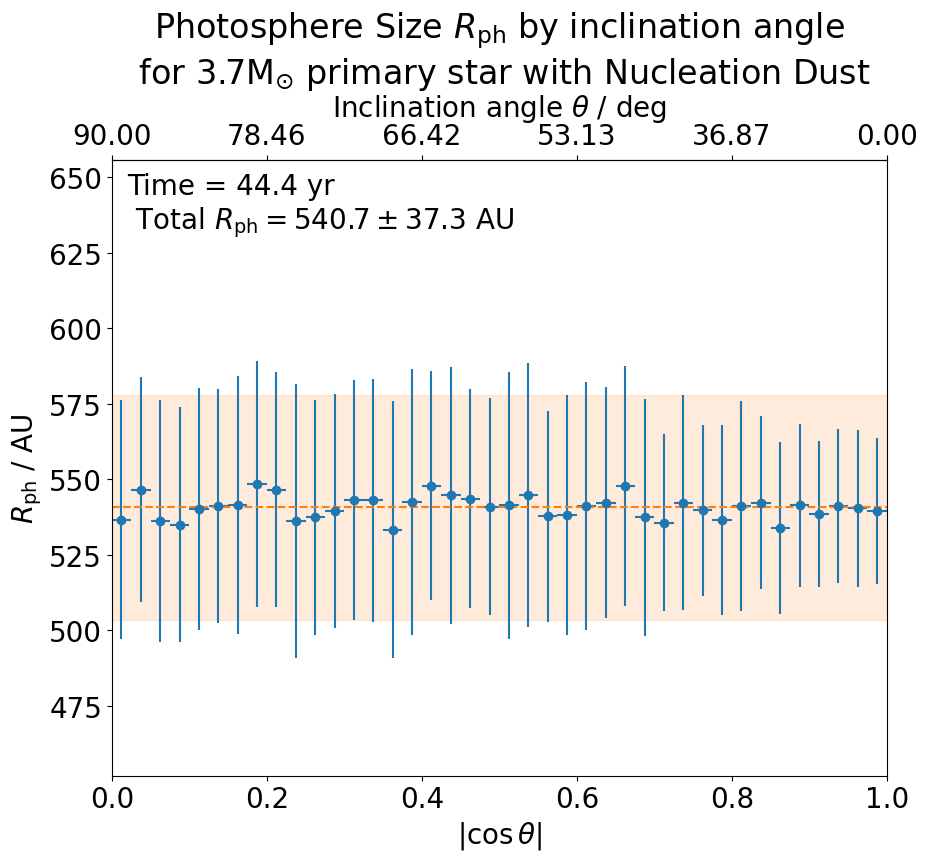

In [7]:
if __name__ == '__main__':
    mpdf = MyPhantomDataFrames()
    

    for cos_theta_sample_no in [None, 80]:
        for job_nickname in ['2md', '4md']:
            for file_index in [0, 2000, 8000, 17600]:
                for var_name in ['T', 'R1']:
                    fig, ax = plot_ph_vals_vs_incl(
                        job_nickname, file_index, var_name,
                        cos_theta_sample_no=cos_theta_sample_no,
                        out_dir=out_dir, mpdf=mpdf, verbose=verbose)

    if is_verbose(verbose, 'note'):
        say('note', '__main__', verbose, f"\n\n\n*** All Done. ***\n\n\n")

.

.

.

# Debug

.

.

.


*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../photosphere/luis_4md/light_00001'


**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
*   Note   :    plot_ph_vals_vs_incl():
	Figure saved to ../fig/4md_00001__photosphere-vals_T-vs-incl_nbin0.png
*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../photosphere/luis_4md/light_00001'


**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY 

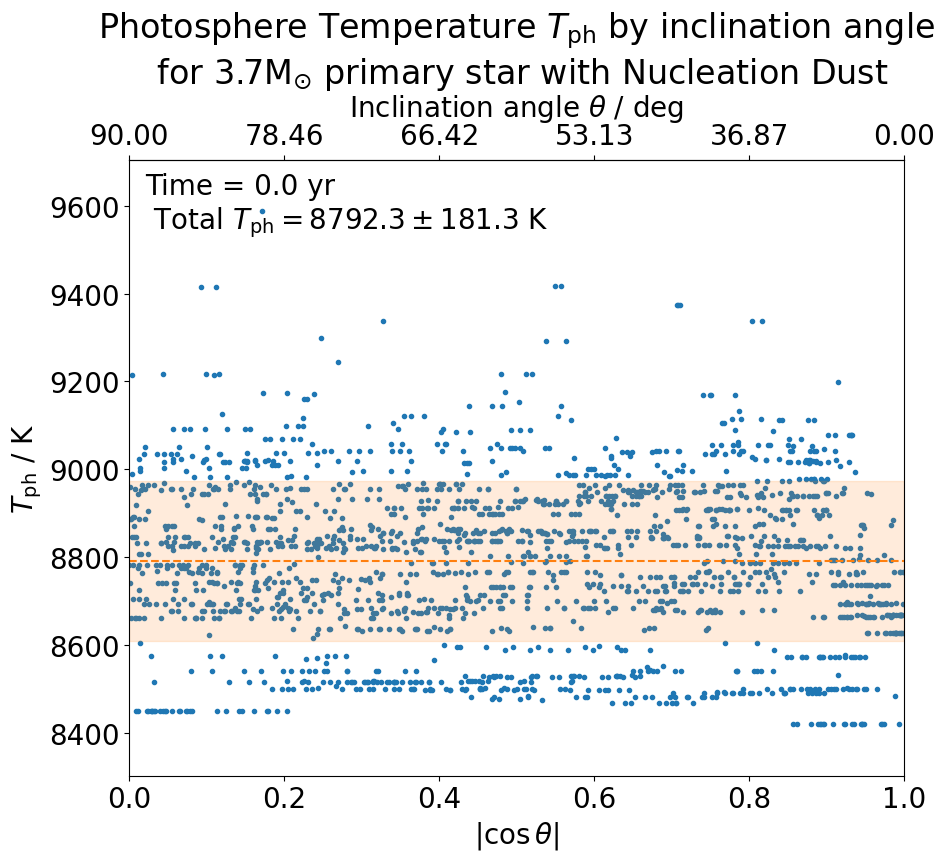

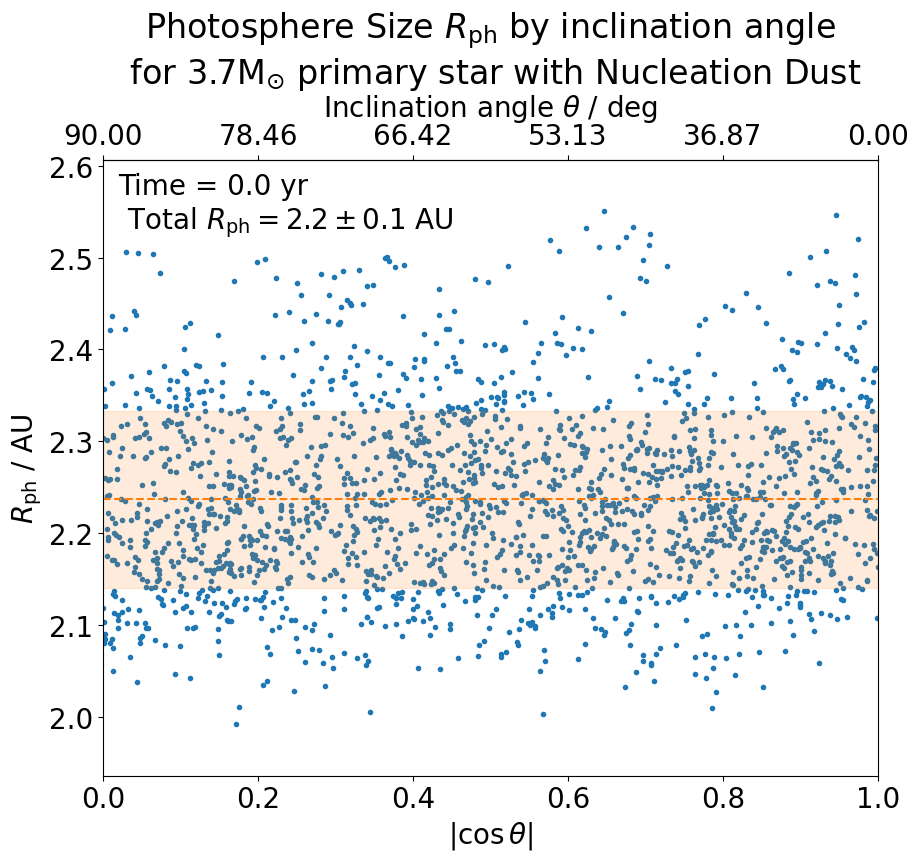

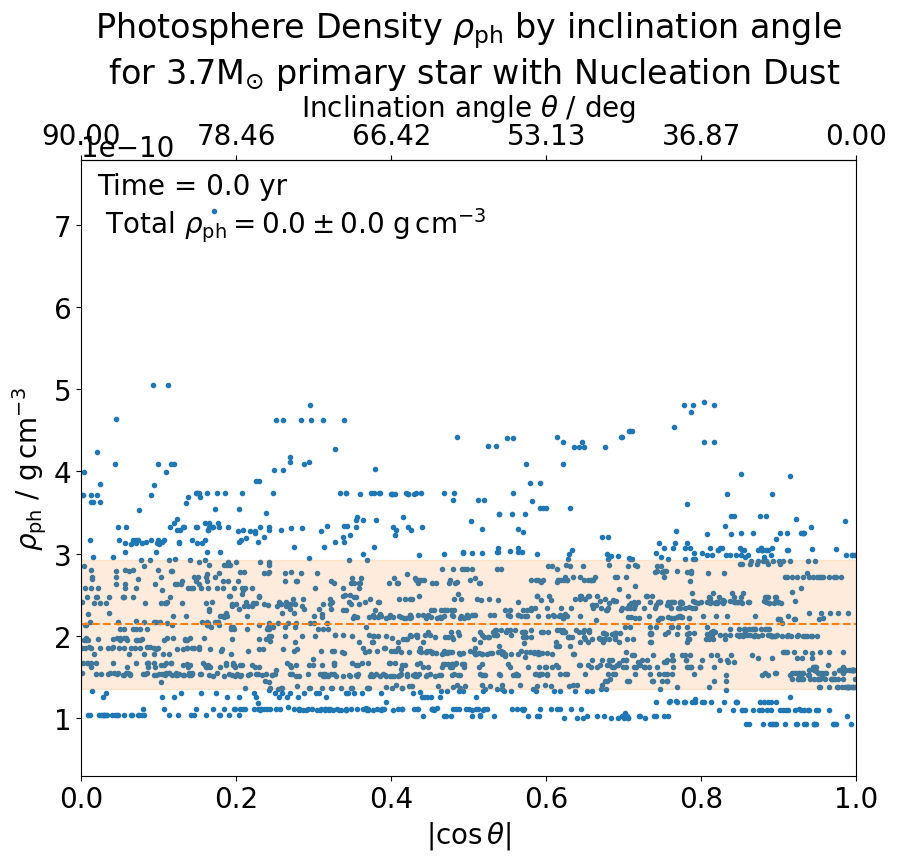

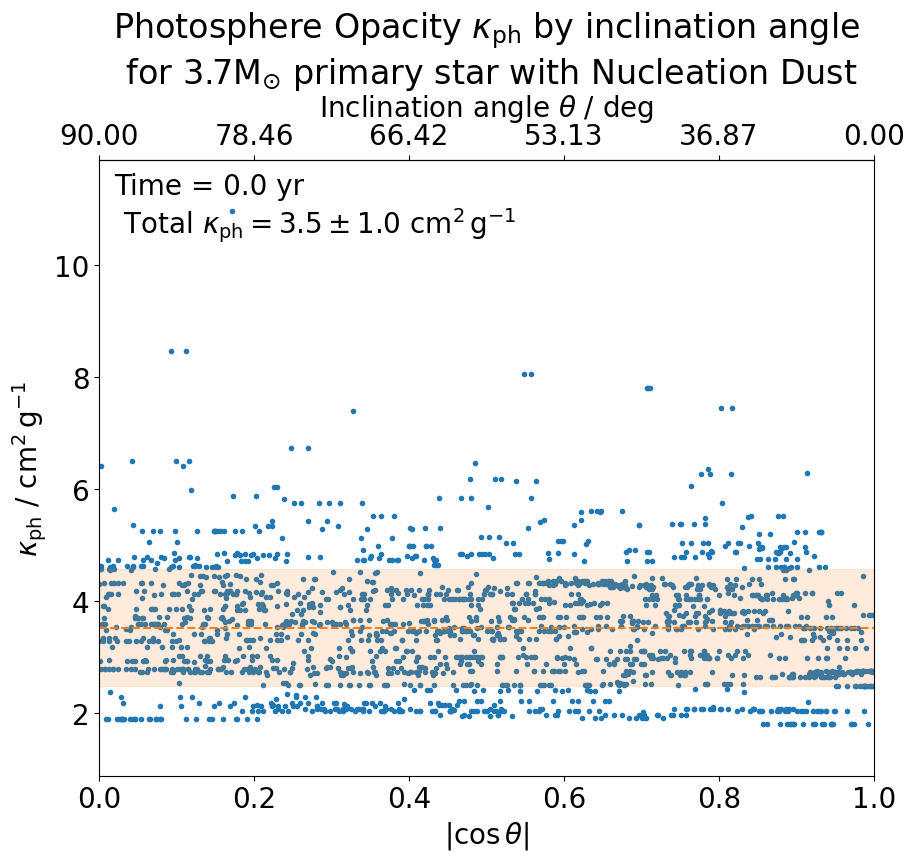

In [91]:
if __name__ == '__main__':
    mpdf = MyPhantomDataFrames()
    

    for cos_theta_sample_no in [None]:
        for job_nickname in ['4md']:
            for file_index in [1]:
                for var_name in ['T', 'R1', 'rho', 'kappa']:
                    fig, ax = plot_ph_vals_vs_incl(
                        job_nickname, file_index, var_name,
                        cos_theta_sample_no=cos_theta_sample_no,
                        out_dir=out_dir, mpdf=mpdf, verbose=verbose)

    if is_verbose(verbose, 'note'):
        say('note', '__main__', verbose, f"\n\n\n*** All Done. ***\n\n\n")

In [8]:
job_nickname = '4md'
file_index   = 2000

job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
ieos        = job_profile['ieos']
eos         = get_eos(ieos, params, settings)
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf        = mpdf_read(job_name, file_index, eos_opacity, verbose=verbose)

*   Note   :    MyPhantomDataFrames.read():
	
	Reading filename='../photosphere/luis_4md/light_02000'

**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = 
		mupl.get_val_in_unit(mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])


    # plotting T vs inclination angle (from both neg and positive cos sides)
    
    if __name__ == '__main__':
        fig, ax = plt.subplots(figsize=(8, 8))
        x = cos_thetas
        xerr = cos_theta_delta
        y_data = [ vals_dict['T'] for vals_dict in vals_by_cos_thetas ]
        y = np.average(y_data, axis = 1)
        yerr =  np.std(y_data, axis = 1)
        #ax.plot(x, y, 'o-')
        #ax.fill_between(x, y-yerr, y+yerr, alpha=0.15)
        ax.errorbar(x, y, yerr, xerr, 'o')
    
        ax.set_xlim((-1., 1.))
        ax.set_ylim((300, 500))
        ax.set_xlabel("$\\cos{\\theta}$")
        ax.set_ylabel(f"$T$ / {mpdf.units['temp']}")
    
        plt.show()

In [67]:
job_profile = JOB_PROFILES_DICT['4md']
file_index  = 0
mpdf        = None

job_name    = job_profile['job_name']
params      = job_profile['params']
ieos        = job_profile['ieos']
eos         = get_eos(ieos, params, settings)
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf        = mpdf_read(job_name, file_index, eos_opacity, mpdf, verbose=verbose)
with open(f"{mpdf.get_filename()}__photosphere-vals.json", 'r') as f:
    vals_dict  = json_load(f)
    vals_dict['abs_cos_theta'] = np.abs( vals_dict['cos_theta'])
mpart          = mpdf.params['massoftype'] * mpdf.units['mass']
hfact          = mpdf.params['hfact']
vals_dict['h'] = (mupl.sph_interp.get_h_from_rho(rho=vals_dict['rho'].cgs, mpart=mpart.cgs, hfact=hfact)*units.cm).to(mpdf.units['dist'])
vals_dict['R1']= vals_dict['R1'].to(mpdf.units['dist'])

*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../photosphere/luis_4md/light_00000'


**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])


In [90]:
for i in range(5):
    print(f"{i=:3d}, {np.count_nonzero(vals_dict['nneigh']==i) = }")
print(f"{i=:3d}, {np.count_nonzero(vals_dict['nneigh']> i) = }")

i=  0, np.count_nonzero(vals_dict['nneigh']==i) = 0
i=  1, np.count_nonzero(vals_dict['nneigh']==i) = 1779
i=  2, np.count_nonzero(vals_dict['nneigh']==i) = 210
i=  3, np.count_nonzero(vals_dict['nneigh']==i) = 10
i=  4, np.count_nonzero(vals_dict['nneigh']==i) = 1
i=  4, np.count_nonzero(vals_dict['nneigh']> i) = 0


In [77]:
vals_dict['h' ] = vals_dict['h' ].to(units.Rsun)
vals_dict['R1'] = vals_dict['R1'].to(units.Rsun)
vals_dict['kappa'] = vals_dict['kappa'].cgs
vals_dict

{'R1': <Quantity [484.66331106, 507.02169162, 528.65699113, ..., 466.4920071 ,
            471.99673385, 481.50519306] solRad>,
 'T': <Quantity [8831.8945366 , 8702.08890954, 8488.90746876, ..., 9050.6937566 ,
            8733.21227787, 8968.73462593] K>,
 'rho': <Quantity [3.23679651e-11, 2.62186606e-11, 1.76308043e-11, ...,
            5.06089861e-11, 4.65824075e-11, 4.16218598e-11] 5.90096 g / cm3>,
 'kappa': <Quantity [3.50306473, 2.82076286, 1.98344933, ..., 4.96392222, 3.51690647,
            4.36379332] cm2 / g>,
 'nneigh': array([1., 1., 1., ..., 1., 1., 1.]),
 'cos_theta': array([-0.56575654, -0.08463539, -0.67400479, ...,  0.80820999,
        -0.22221337,  0.15921991]),
 'ray_unit_vec': array([[ 0.37404891,  0.73485165, -0.56575654],
        [-0.19186056,  0.97776601, -0.08463539],
        [ 0.19786783, -0.7117344 , -0.67400479],
        ...,
        [-0.5190868 , -0.27811059,  0.80820999],
        [-0.42558501,  0.8772107 , -0.22221337],
        [ 0.00628401,  0.98722314,  0

In [53]:
np.average(vals_dict['h']), np.std(vals_dict['h'])

(<Quantity 48.4005266 solRad>, <Quantity 5.8984604 solRad>)

In [52]:
np.average(vals_dict['R1']), np.std(vals_dict['R1'])

(<Quantity 480.86289973 solRad>, <Quantity 20.93819047 solRad>)

In [69]:
np.average(vals_dict['kappa']), np.std(vals_dict['kappa'])

(<Quantity 3.55852921 cm2 / g>, <Quantity 1.04907401 cm2 / g>)

In [76]:
np.average(vals_dict['rho'].cgs), np.std(vals_dict['rho'].cgs)

(<Quantity 2.16031423e-10 g / cm3>, <Quantity 8.036891e-11 g / cm3>)

In [75]:
np.average(vals_dict['h'].cgs), np.std(vals_dict['h'].cgs)

(<Quantity 3.36722464e+12 cm>, <Quantity 4.1035589e+11 cm>)

In [81]:
vals_dict['tau_estimate'] = (vals_dict['kappa']*vals_dict['rho']*vals_dict['h']).to_value(units.dimensionless_unscaled)

In [83]:
np.average(vals_dict['tau_estimate']), np.std(vals_dict['tau_estimate'])

(2640.407762804697, 1426.4846666323972)

In [73]:
4*pi*480**2/(48**2)

1256.6370614359173

In [71]:
eos_opacity.get_kappa(rho=3e-11, T=8500)

1.351652488736986

In [21]:
help(mupl.sph_interp.get_h_from_rho)

Help on CPUDispatcher in module main.clmuphantomlib.sph_interp:

get_h_from_rho(rho: numpy.ndarray | float, mpart: float, hfact: float, ndim: int = 3) -> numpy.ndarray | float
    Getting smoothing length from density.
    
    Assuming Phantom, where smoothing length h is dynamically scaled with density rho using
    rho = hfact**ndim * (m / h**ndim)
    for ndim-dimension and hfact the constant.
    So,
    h = hfact * (mpart / rho)**(1./ndim)

